In [2]:

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
writer = SummaryWriter()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

default_params = {
    "batch_size_train": 64,
    "batch_size_test" : 100,
    "random_seed"     : 48,
    "learning_rate"   : 0.001,
    "momentum"        : 0.03

}

In [4]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dataset_mnist = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transformers)
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=default_params["batch_size_train"], shuffle=True)
test_dataset_mnist = torchvision.datasets.MNIST('./data', train=False,download=True, transform=transformers)
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=default_params["batch_size_test"], shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
resnet18 = models.resnet18()
vgg = models.vgg16()

In [ ]:
def get_class_count(dataset):
  class_dict = {} 
  for img, label in dataset:
    class_dict[label] = class_dict.get(label, 0) + 1
  for label in class_dict.keys(): 
    print("Images belonging to " + str(label) + " are: " + str(class_dict[label]))

In [ ]:
get_class_count(train_dataset_mnist)

Images belonging to 5 are: 5421
Images belonging to 0 are: 5923
Images belonging to 4 are: 5842
Images belonging to 1 are: 6742
Images belonging to 9 are: 5949
Images belonging to 2 are: 5958
Images belonging to 3 are: 6131
Images belonging to 6 are: 5918
Images belonging to 7 are: 6265
Images belonging to 8 are: 5851


In [8]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=default_params["learning_rate"],momentum=default_params["momentum"])
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
val_size = 5000
train_size = len(train_dataset_mnist) - val_size
train_ds_mnist, val_ds_mnist = random_split(train_dataset_mnist, [train_size, val_size])
val_loader_mnist = torch.utils.data.DataLoader(val_ds_mnist, default_params['batch_size_train']*2)
print("Number of samples in training = {} and validation dataset = {} for MNIST dataset".format(len(train_ds_mnist), len(val_ds_mnist)))


Number of samples in training = 55000 and validation dataset = 5000 for MNIST dataset


In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
train_loader = DeviceDataLoader(train_loader_mnist, device)
val_loader = DeviceDataLoader(val_loader_mnist, device)
test_loader = DeviceDataLoader(test_loader_mnist, device)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
class CRNN(ImageClassificationBase):
    def __init__(self,resnet18, vgg):
        super(CRNN, self).__init__()
        self.features_resnet = nn.Sequential(*(list(resnet18.children())[0:8]))
        self.features_vgg = nn.Sequential(*list(vgg.features))
        
        
        self.cnn1 =  nn.Conv2d(512, 128, 7)
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32,10)
        )
        self.flat = nn.Flatten()
    def forward(self, inputs):
        resnet_feature = self.features_resnet(inputs)
        resnet_feature = self.cnn1(resnet_feature)

        vgg_feature = self.features_vgg(inputs)
        vgg_feature = self.cnn1(vgg_feature)        


        f = torch.cat((vgg_feature, resnet_feature),1)
        f = self.flat(f)
        
        y  = self.classifier(f)
        
        return y

network = CRNN(resnet18, vgg)

In [20]:
network = to_device(network, device)
history = [evaluate(network, val_loader)]
history+= fit(10 , network, train_loader, val_loader)


Epoch [0], val_loss: 0.2925, val_acc: 0.9178
Epoch [1], val_loss: 0.2379, val_acc: 0.9324


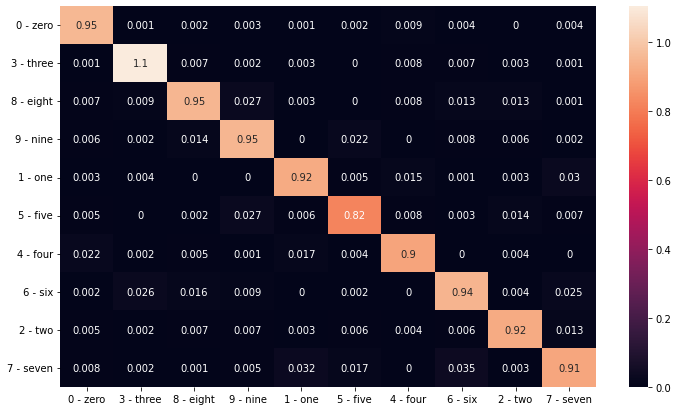

In [21]:
def print_confusion_matrix(test_loader, classes):
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    output = network(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')
print_confusion_matrix(test_loader,set(test_dataset_mnist.classes))

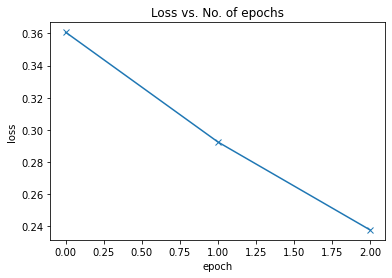

In [22]:
plot_losses(history)

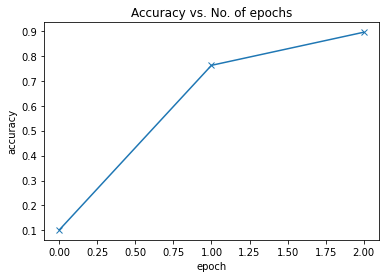

In [18]:
plot_accuracies(history)